In [2]:
import numpy as np
import matplotlib.pyplot as plt
import funkcjeCpp as cpp
import math
import copy
import os
import pickle
import import_ipynb
import Prepare_time_series as pts
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import sys
import time
from concurrent.futures import ProcessPoolExecutor
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import SpectralClustering

importing Jupyter notebook from Prepare time series.ipynb


/usr/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# 0. Załadować wyliczoną macierz odległości między szeregami
# 2. Aglorytmem ewolucyjnym generować nowe shaplety i dopasowywać stare
#    a) Jeśli dodajemy nowy shaplet to po prostu wylosopwujemy ileś i dodajemy najlepszy
#    b) Modyfikacja starego:
#        - zmiana długości
#        - przesunięcie w prawo lub w lewo (okna na wzorcu, 
#          ponieważ podczas wyliczania odległości i tak przesuwamy się po wszystkich możliwych oknach)
#    c) Funkcja zysku: silouete indeks dla wszystkich danych, powiększony o najniższy silhouete score
#       z pośród tych wyliczonych dla poszczególnych grup, pomnożony przez Alpha

In [ ]:
pts.sciezki=["../Dane/Fasta/Borrelia/GCF_000008685.2_ASM868v2_cds_from_genomic.fna"]
szeregi=np.array(pts.przygotujSzeregiCzasowe(50,256), dtype=np.float32)
skaler=TimeSeriesScalerMinMax()
szeregi=skaler.fit_transform(szeregi.reshape(*szeregi.shape,1))
szeregi=np.array(szeregi.squeeze(),dtype=np.float32)

In [7]:
KatalogPickli="Pickle"

In [5]:
class Ksztalt():
    def __init__(self, wartosci, indSzer, indPocz):
        self.indeksSzereguRodzica=indSzer
        self.poczatekWRodzicu=indPocz
        self.dl=len(wartosci)
        self.ksztalt=wartosci
        
class AlgorytmEwolucyjny():
    def __init__(self, algGrupujacy, fSilIndCalosc, fSilIndGrupy, poczDlKsztaltu, liczbaGrup):
        self.algGrupujacy=algGrupujacy
        self.fSilIndCalosc=fSilIndCalosc
        self.fSilIndGrupy=fSilIndGrupy
        self.poczDlKsztaltu=poczDlKsztaltu
        self.liczbaGrup=liczbaGrup
        self.historia=[]
        
    @staticmethod
    def generujKsztalt(szeregi, dlKsztaltu):
        indSzer=np.random.randint(0,szeregi.shape[0])
        indOkna=np.random.randint(0,szeregi.shape[1]-dlKsztaltu)
        return Ksztalt(szeregi[indSzer,indOkna:indOkna+dlKsztaltu], indSzer,indOkna)
    
    def inicjalizujPopulacje(self, szeregi, poczatkowaLiczbaOsobnikow=10,
                            poczatkowyRozmiarZbioruKsztaltow=3):
        populacja=[]
        for i in range(poczatkowaLiczbaOsobnikow):
            zbiorKsztaltow=[]
            for j in range(poczatkowyRozmiarZbioruKsztaltow):
                zbiorKsztaltow.append(self.generujKsztalt(szeregi, self.poczDlKsztaltu))
            populacja.append(zbiorKsztaltow)
        return populacja
        
    def mutacjaPrzesuniecia(self, zbiorKsztaltow, szeregi):
        r=np.random.randn()*5
        if(r>0):
            r=math.ceil(r)
        else:
            r=math.floor(r)
        i=np.random.randint(0,len(zbiorKsztaltow))
        ksztalt=zbiorKsztaltow[i]
        rodzic=szeregi[ksztalt.indeksSzereguRodzica]
        if 0<=ksztalt.poczatekWRodzicu+r<=len(rodzic)-ksztalt.dl:
            ksztalt.poczatekWRodzicu+=r
            ksztalt.ksztalt=rodzic[ksztalt.poczatekWRodzicu:ksztalt.poczatekWRodzicu+ksztalt.dl]
            
    def mutacjaZmianyDlugosci(self, zbiorKsztaltow, szeregi):
        r=np.random.randint(0,2)
        i=np.random.randint(0,len(zbiorKsztaltow))
        ksztalt=zbiorKsztaltow[i]
        rodzic=szeregi[ksztalt.indeksSzereguRodzica]
        if(r==0):
            nowaDl=ksztalt.dl-8
        else:
            nowaDl=ksztalt.dl+8
        if 0<nowaDl:
            ksztalt.dl=nowaDl
            ksztalt.ksztalt=rodzic[ksztalt.poczatekWRodzicu:ksztalt.poczatekWRodzicu+ksztalt.dl]
    
    def mutacjaDodaniaNowegoKsztaltu(self, zbiorKsztaltow, szeregi):
        zbiorKsztaltow.append(self.generujKsztalt(szeregi, self.poczDlKsztaltu))
    
    def mutacja(self, zbiorKsztaltow, szeregi):
        r=np.random.choice(3,p=[0.5,0.3,0.2])
        if (r==0):
            self.mutacjaPrzesuniecia(zbiorKsztaltow, szeregi)
        if (r==1):
            self.mutacjaZmianyDlugosci(zbiorKsztaltow, szeregi)
        if (r==2):
            self.mutacjaDodaniaNowegoKsztaltu(zbiorKsztaltow, szeregi)
    
    def krzyzuj(self, rod1, rod2):
        r1=np.round(np.random.rand(len(rod1)))
        r2=np.round(np.random.rand(len(rod2)))
        
        dziecko1=[]
        dziecko2=[]
        for rodzic,r in [(rod1,r1),(rod2,r2)]:
            for i in range(len(rodzic)):
                if r[i]==0:
                    dziecko1.append(copy.deepcopy(rodzic[i]))
                else:
                    dziecko2.append(copy.deepcopy(rodzic[i]))
        return dziecko1, dziecko2
    
    def wybierzOsobnikiDoMutacji(self, populacja, ocenaPopulacji, liczbOsobnikowDoWygenerowania):
        ppb=ocenaPopulacji/np.sum(ocenaPopulacji)
        indeksy=np.random.choice(len(populacja), liczbOsobnikowDoWygenerowania,p=ppb)
        doMutowania=[]
        for i in range(0,len(indeksy),2):
            dziecko1, dziecko2=self.krzyzuj(populacja[indeksy[i]], populacja[indeksy[i+1]])
            doMutowania.append(dziecko1)
            doMutowania.append(dziecko2)
        if len(indeksy)%2==1:
            doMutowania.append(copy.deepcopy(populacja[indeksy[-1]]))
        return doMutowania
    
    def mutujOsobniki(self, doMutowania, szeregi):
        for zbiorKsztaltow in doMutowania:
            self.mutacja(zbiorKsztaltow, szeregi)
    
    def ocenPojedynczyZbior(self, zbiorKsztaltow, szeregi):
        ksztaltyNp=[k.ksztalt for k in zbiorKsztaltow]
        t=time.time()
        odl=cpp.odlegloscMiedzySzeregamiAListaKsztaltow(szeregi, ksztaltyNp)
        #global odlC
        #odlC=copy.deepcopy(odl)
        #print("Odl", odl.shape, odl.dtype)
        #print("Odl time",time.time()-t)
        instancjaAlgorytmu=self.algGrupujacy(7)
        #print("Creating",time.time()-t)
        etykiety=instancjaAlgorytmu.fit_predict(odl)
        #print("Predicting",time.time()-t)
        silCalosci=self.fSilIndCalosc(etykiety)
        #print("All",time.time()-t)
        return silCalosci
    
    def ocenPopulacje(self, populacja, szeregi):
        with ProcessPoolExecutor() as pool:
            obietnice=[pool.submit(self.ocenPojedynczyZbior,zbiorKsztaltow, szeregi) for
                      zbiorKsztaltow in populacja]
        oceny=[ob.result() for ob in obietnice]
        #print(len(populacja))
        #oceny=[self.ocenPojedynczyZbior(zbiorKsztaltow, szeregi) for zbiorKsztaltow in populacja]
        return oceny
    
    def przeprowadzSelekcje(self, populacja, ocenaPopulacji, liczbaOsobnikowPrzezywajacych):
        ppb=np.array(ocenaPopulacji)
        ppb-=np.min(ppb)
        ppb/=np.sum(ppb)
        wybrane=np.random.choice(len(populacja),size=liczbaOsobnikowPrzezywajacych,
                                 replace=False,p=ppb)
        nowaPopulacja=[populacja[ind] for ind in wybrane]
        ocenyNowejPopulacji=[ocenaPopulacji[ind] for ind in wybrane]
        return nowaPopulacja, ocenyNowejPopulacji
    
    def zapiszHistorie(self, populacja, ocenaPopulacji):
        ind=np.argmax(ocenaPopulacji)
        self.historia.append((copy.deepcopy(populacja[ind]),ocenaPopulacji[ind]))
    
    def ewolucja(self, szeregi, liczbaGeneracji, liczbaOsobnikow=40,
                 liczbaDzieci=40, poczRozmiarZbioruKsztaltow=3):
        #print("pocz")
        populacja=self.inicjalizujPopulacje(szeregi, liczbaOsobnikow,poczRozmiarZbioruKsztaltow)
        #print("ocena1")
        ocenaPopulacji=self.ocenPopulacje(populacja, szeregi)
        for i in range(liczbaGeneracji):
            #print("wybór")
            doMutowania=self.wybierzOsobnikiDoMutacji(populacja, ocenaPopulacji, liczbaDzieci)
            #print("mutowanie")
            self.mutujOsobniki(doMutowania, szeregi)
            #print("ocena")
            ocenaZmutowanych=self.ocenPopulacje(doMutowania, szeregi)
            populacja.extend(doMutowania)
            ocenaPopulacji.extend(ocenaZmutowanych)
            #print("selekcja")
            populacja, ocenaPopulacji=self.przeprowadzSelekcje(populacja, ocenaPopulacji, liczbaOsobnikow)
            self.zapiszHistorie(populacja, ocenaPopulacji)
            if(i%5==0):
                print(f"Zakończono generację: {i}")
        

In [5]:
with open(os.path.join(KatalogPickli, "borrelia-odleglosciMiedzySzeregami-normalized-softdtw"), "rb") as plik:
    odlSoftDtw=pickle.load(plik)

In [6]:
def ocenaCalosciowaSilhoette(etykiety):
    return silhouette_score(odlSoftDtw, etykiety, metric="precomputed")+1

# Z krzyżowaniem

In [26]:
algEwolucyjny=AlgorytmEwolucyjny(KMeans,
                                 ocenaCalosciowaSilhoette, 
                                 None, 40,7)

In [ ]:
algEwolucyjny.ewolucja(szeregi, 220, 40, 40,
                       poczRozmiarZbioruKsztaltow=30)

In [29]:
with open(os.path.join(KatalogPickli, f"borrelia-shaplety-krzyzowanie-kmeans{str(time.time())}"), "wb") as plik:
    pickle.dump(algEwolucyjny.historia,plik)

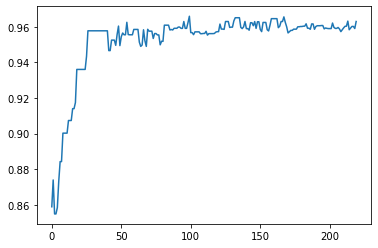

In [30]:
wyniki=[w[1] for w in algEwolucyjny.historia]
plt.plot(wyniki)

## Spektralne

In [7]:
algEwolucyjny=AlgorytmEwolucyjny(SpectralClustering,
                                 ocenaCalosciowaSilhoette, 
                                 None, 40,7)

In [ ]:
algEwolucyjny.ewolucja(szeregi, 250, 50, 50,
                       poczRozmiarZbioruKsztaltow=30)

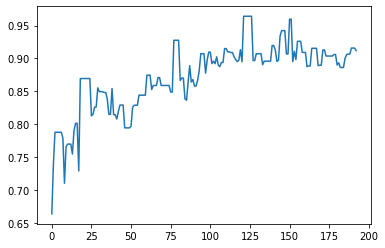

In [9]:
wyniki=[w[1] for w in algEwolucyjny.historia]
plt.plot(wyniki)

In [10]:
with open(os.path.join(KatalogPickli, f"borrelia-shaplety-krzyzowanie-spektralne{str(time.time())}"), "wb") as plik:
    pickle.dump(algEwolucyjny.historia,plik)

# Bez krzyzowania, początkowa długosć kształtu: 16

## Kmeans

In [22]:
kmeans=KMeans(n_clusters=7)

In [23]:
algEwolucyjny2=AlgorytmEwolucyjny(KMeans,
                                 ocenaCalosciowaSilhoette, 
                                 None, 16,7)

In [ ]:
algEwolucyjny2.ewolucja(szeregi, 200, 50, 50)

In [25]:
with open(os.path.join(KatalogPickli, f"borrelia-shaplety-{str(time.time())}"), "wb") as plik:
    pickle.dump(algEwolucyjny2.historia,plik)

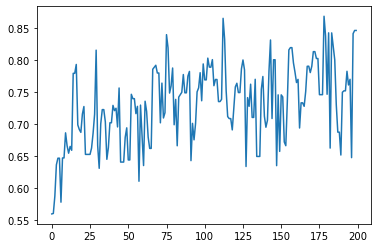

In [31]:
wyniki=[w[1] for w in algEwolucyjny2.historia]
plt.plot(wyniki)

In [27]:
np.argmax(wyniki)

103

In [28]:
ksztalty=algEwolucyjny.historia[103][0]

In [29]:
ksztalty

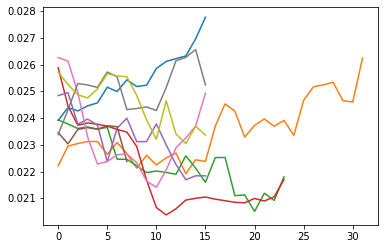

In [49]:
for k in ksztalty:
    plt.plot(k.ksztalt)

## Spektralne

In [16]:
from sklearn.cluster import SpectralClustering

In [20]:
algEwolucyjny=AlgorytmEwolucyjny(SpectralClustering,
                                 ocenaCalosciowaSilhoette, 
                                 None, 16,7)

In [ ]:
algEwolucyjny.ewolucja(szeregi, 200, 30, 30)

In [30]:
with open(os.path.join(KatalogPickli, f"borrelia-shaplety-spektralne-{str(time.time())}"), "wb") as plik:
    pickle.dump(algEwolucyjny.historia,plik)

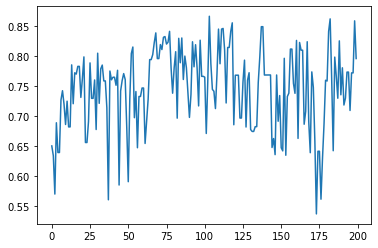

In [32]:
wyniki=[w[1] for w in algEwolucyjny.historia]
plt.plot(wyniki)

# Smoothed timeseries

In [13]:
with open("Pickle/Borrelia-wygladzone.pickle","rb") as file:
    szeregiWyg=pickle.load(file)
szeregiWyg=szeregiWyg.squeeze()

In [8]:
with open(os.path.join(KatalogPickli, "borrelia-wygladzone-odleglosciMiedzySzeregami-normalized-softdtw"), "rb") as plik:
    odlSoftDtw=pickle.load(plik)

In [9]:
def ocenaCalosciowaSilhoette(etykiety):
    return silhouette_score(odlSoftDtw, etykiety, metric="precomputed")+1

In [14]:
algEwolucyjny=AlgorytmEwolucyjny(KMeans,
                                 ocenaCalosciowaSilhoette, 
                                 None, 40,7)

In [15]:
algEwolucyjny.ewolucja(szeregiWyg, 150, 50, 50,
                       poczRozmiarZbioruKsztaltow=30)

Zakończono generację: 0
Zakończono generację: 5
Zakończono generację: 10
Zakończono generację: 15
Zakończono generację: 20
Zakończono generację: 25
Zakończono generację: 30
Zakończono generację: 35
Zakończono generację: 40
Zakończono generację: 45
Zakończono generację: 50
Zakończono generację: 55
Zakończono generację: 60
Zakończono generację: 65
Zakończono generację: 70
Zakończono generację: 75
Zakończono generację: 80
Zakończono generację: 85
Zakończono generację: 90
Zakończono generację: 95
Zakończono generację: 100
Zakończono generację: 105
Zakończono generację: 110
Zakończono generację: 115
Zakończono generację: 120
Zakończono generację: 125
Zakończono generację: 130
Zakończono generację: 135
Zakończono generację: 140
Zakończono generację: 145


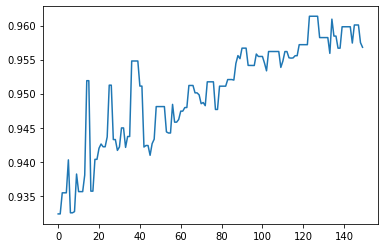

In [16]:
wyniki=[w[1] for w in algEwolucyjny.historia]
plt.plot(wyniki)